In [1]:
import os

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from custom_dataloader import CustomDataset

# Define the directory where your data is located
data_dir = './Rice_Image_Dataset/'

# Define the transformation for the images.
# You might need to adjust the resizing, normalization values based on your specific needs.
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Create the dataset
dataset = CustomDataset(data_dir, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

# Example: Iterate through the DataLoader (just to show how it works)
# You can remove this part in your actual training loop
for images, labels in dataloader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break  # Remove this break to iterate through the whole dataset


Batch images shape: torch.Size([128, 3, 128, 128])
Batch labels shape: torch.Size([128, 5])


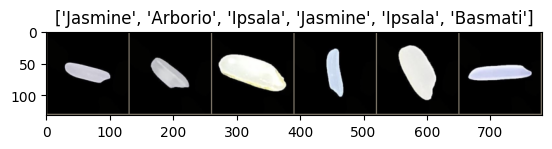

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

#Visualize a random set of  images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:6])

# Convert the labels from one-hot to integer labels for displaying
_, labels = torch.max(classes[:6], 1)
labels = labels.numpy()

# Map integer labels to class names
label_names = [dataset.classes[label] for label in labels]

imshow(out, title=label_names)


In [4]:
#Creating test, train & validations dataloaders
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Assuming 'dataset' is your CustomDataset instance and 'targets' are class indices
targets = [y for _, y in dataset.samples]  # Adjust this line if necessary to match your dataset structure

# Split the dataset into a training+validation set and a separate test set (stratified)
train_val_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,  # 20% for the test set
    stratify=targets,
    random_state=42
)

# Further split the training+validation set into individual training and validation sets (stratified)
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.25,  # Results in 20% of the original dataset for validation
    stratify=[targets[i] for i in train_val_indices],
    random_state=42
)

# Subset the dataset based on indices to create train, validation, and test datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders for each dataset subset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)



In [5]:
import torchvision.models as models

# List all attributes in torchvision.models that are callable (i.e., functions/classes)
# This will include models and possibly other callable utilities
model_names = [model_name for model_name in dir(models) if callable(getattr(models, model_name))]

print(model_names)


['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

In [9]:
# Load the pre-trained model
pretrained_model = models.resnet34(pretrained=True)


/Users/surya/Documents/personal/kaggle/venv_kaggle/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/surya/Documents/personal/kaggle/venv_kaggle/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
from torch import nn
num_classes = len(dataset.classes)  # Replace 'dataset' with your actual dataset variable

# Replace the last fully connected layer with a new one
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

In [13]:
# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
pretrained_model.to(device)

epochs = 10  # Define the number of epochs

for epoch in range(epochs):
    pretrained_model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_index, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        # Print loss for every batch
        if batch_index % 25 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_index}/{len(train_loader)}, Loss: {loss.item()}")
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss}")

    pretrained_model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = pretrained_model(inputs)
            loss = criterion(outputs, labels)
            
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss}")

Epoch 1, Batch 25/352, Loss: 0.05344858765602112
Epoch 1, Batch 50/352, Loss: 0.05708025395870209
Epoch 1, Batch 75/352, Loss: 0.008844989351928234
Epoch 1, Batch 100/352, Loss: 0.012547696009278297
Epoch 1, Batch 125/352, Loss: 0.015784593299031258
Epoch 1, Batch 150/352, Loss: 0.0012293234467506409
Epoch 1, Batch 175/352, Loss: 0.05764911323785782
Epoch 1, Batch 200/352, Loss: 0.012740721926093102
Epoch 1, Batch 225/352, Loss: 0.05006202682852745
Epoch 1, Batch 250/352, Loss: 0.024134498089551926
Epoch 1, Batch 275/352, Loss: 0.03780154883861542
Epoch 1, Batch 300/352, Loss: 0.012572157196700573
Epoch 1, Batch 325/352, Loss: 0.03164175897836685
Epoch 1, Batch 350/352, Loss: 0.0024898750707507133
Epoch 1 completed. Average Loss: 0.046842675027206
Epoch 1, Average Validation Loss: 0.17916649800993628
Epoch 2, Batch 25/352, Loss: 0.0013749541249126196
Epoch 2, Batch 50/352, Loss: 0.03961382061243057
Epoch 2, Batch 75/352, Loss: 0.002788163023069501
Epoch 2, Batch 100/352, Loss: 0.002280

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Test the model performance
correct = 0
total = 0
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted.shape, labels.shape)
        # Convert labels from one-hot encoded to class indices if necessary
        labels = torch.argmax(labels, dim=1)
    
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Out of {total} test images, {correct} correct classifications')
print(f'Accuracy on the test images: {accuracy:.2f}%')

# Calculate additional metrics
precision = precision_score(all_true_labels, all_predictions, average='macro')
recall = recall_score(all_true_labels, all_predictions, average='macro')
f1 = f1_score(all_true_labels, all_predictions, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Out of 15000 test images, 14885 correct classifications
Accuracy on the test images: 99.23%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
